<a href="https://colab.research.google.com/github/joey0629/chatWeb/blob/master/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#Colab資料夾設定方法
!pip install google.colab #如未安裝取消註解後執行
import os

from google.colab import drive
drive.mount('/content/drive')
!pwd
##出現提示欄進行授權

os.chdir('/content/drive/MyDrive/CNN') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CNN


['model.weights.h5', '.ipynb_checkpoints']

# 以下為DL model


In [11]:
!pip install captcha
!pip install --upgrade tensorflow
!pip install matplotlib
!pip install --upgrade keras
#!pip install --upgrade deepsegment

In [31]:
!pip install opencv-python

In [ ]:
!pip install -U tensorflow keras  # Keras-CV needs TF 2.15 when used with Keras 3
!pip install -U keras-cv
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.8 MB/s eta 0:00:00


In [12]:
import keras
print(keras.__version__)

3.3.3


In [13]:
# 0-9，A-Z，总共36个类别
# characters = string.digits + string.ascii_uppercase
# print(characters)
characters = "0123456789ABCDEFGHJKLMNPQRSTUVWXYZ"
width, height, n_len, n_class = 170, 80, 4, len(characters)
n_classes = len(characters)
print(n_classes)

34


In [14]:
# -*- coding: utf-8 -*-
from captcha.image import ImageCaptcha
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
#from tensorflow.keras.utils.np_utils import to_categorical

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16
import string
from tqdm import tqdm

def gen(batch_size=16, height=80, width=170, n_len=4, n_class=34):
    """
    生成器，默认每次生成16张验证码样本
    :param batch_size: 每次生成验证码个数
    :param height: 图片高度
    :param width: 图片宽度
    :param n_len: 验证码中数字/字母的个数
    :param n_class: 类别数

    :yield:
        :X: 图片数据，of shape (batch_size, height, width, 3)
        :y: one-hot 标签数据, of shape (batch_size, n_len, n_class)
    """
    # characters = string.digits + string.ascii_uppercase
    characters = "0123456789ABCDEFGHJKLMNPQRSTUVWXYZ"
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len, n_class), dtype=np.uint8)
    generator = ImageCaptcha(width=width, height=height)

    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[i, j, characters.find(ch)] = 1
        yield X, y


def decode(y):
    """
    将模型输出的 one-hot 解码成相应的4个数字/字母
    :param y: one-hot
    :return:
    """
    # characters = string.digits + string.ascii_uppercase
    characters = "0123456789ABCDEFGHJKLMNPQRSTUVWXYZ"
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])



def model(height, width):
    """
    神经网络模型
    :param height: 图片高度
    :param width: 图片宽度
    :return:
    """
    input_tensor = keras.src.Input((height, width, 3))
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = Dropout(0.25)(x)
    x = [Dense(n_class, activation='softmax', name='c%d' % (i + 1))(x) for i in range(4)]
    x = keras.layers.Concatenate(axis=1)(x)  # Concatenate the outputs
    x = keras.layers.Reshape((4, n_class))(x)  # Reshape the output
    model = keras.src.Model(inputs=base_model.input, outputs=x)
    # model.load_weights('/content/drive/MyDrive/CNN/model.weights.h5')
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    # Create a tf.data.Dataset from the generator
    train_dataset = tf.data.Dataset.from_generator(
        lambda: gen(),
        output_signature=(
            tf.TensorSpec(shape=(None, height, width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4, n_class), dtype=tf.float32)  # Adjust the target shape
        )
    ).prefetch(tf.data.AUTOTUNE)

    validation_dataset = tf.data.Dataset.from_generator(
        lambda: gen(),
        output_signature=(
            tf.TensorSpec(shape=(None, height, width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4, n_class), dtype=tf.float32)  # Adjust the target shape
        )
    ).prefetch(tf.data.AUTOTUNE)

    # Use the dataset in the fit method
    model.fit(train_dataset, steps_per_epoch=64, epochs=5,
              validation_data=validation_dataset, validation_steps=1280)

    # 保存模型权重
    model.save_weights("/content/drive/MyDrive/CNN/model_2.weights.h5")


    return model

def evaluate(model, batch_num=200):
    """
    计算模型的总体准确率
    :param model:
    :param batch_num:
    :return:
    """
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred)))

    return batch_acc / batch_num



In [15]:
def test_model(model, num_tests=10):
    """
    測試模型的預測結果
    :param model: 要測試的模型
    :param num_tests: 要進行的測試數量
    :return: None
    """
    characters = string.digits + string.ascii_uppercase
    width, height, n_len, n_class = 170, 80, 4, len(characters)
    generator = gen2(1, height, width, n_len, n_class)

    for i in range(num_tests):
        X, y_true = next(generator)
        y_pred = model.predict(X)
        y_true = decode(y_true)
        y_pred = decode(y_pred)

        if y_true == y_pred:
            print(f"Test {i+1}: Success! True = {y_true}, Predicted = {y_pred}")
        else:
            print(f"Test {i+1}: Fail. True = {y_true}, Predicted = {y_pred}")


In [16]:
from keras.models import load_model
# 定義輸入張量
input_tensor = Input(shape=(height, width, 3))

# 加載預訓練的VGG16模型，不包括頂部的全連接層
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 獲取VGG16的輸出
x = base_model.output
x = Flatten()(x)  # 展平特徵圖
x = Dropout(0.25)(x)  # 添加Dropout層

# 為每個類別創建獨立的全連接層，然後將它們連接在一起
x = [Dense(n_class, activation='softmax', name='c%d' % (i + 1))(x) for i in range(4)]
x = Concatenate(axis=1)(x)  # 將輸出連接起來
x = Reshape((4, n_class))(x)  # 將輸出重塑為(4, n_class)的形狀

# 定義最終的模型
model = Model(inputs=base_model.input, outputs=x)

# 檢查模型架構
model.summary()

# 加載已經訓練好的模型權重
# model.load_weights('/content/drive/MyDrive/CNN/model.weights.h5')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80, 170, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 80, 170, 64)    │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 80, 170, 64)    │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 40, 85, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 40, 85, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 40, 85, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 20, 42, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 20, 42, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 20, 42, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 20, 42, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 10, 21, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 10, 21, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 10, 21, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 10, 21, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 5, 10, 512)     │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 5, 10, 512)     │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 5, 10, 512)     │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 15,411,144 (58.79 MB)

 Trainable params: 15,411,144 (58.79 MB)

 Non-trainable params: 0 (0.00 B)

# CNN VGG 16 with normalization and dropout

In [57]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.models import Model

def vgg16_with_batchnorm_dropout(input_shape=(80, 170, 3), n_class=34, dropout_rate=0.25):
    """
    構建帶有BatchNormalization和Dropout的VGG16模型
    :param input_shape: 輸入圖像的形狀
    :param n_class: 類別數
    :param dropout_rate: Dropout的比例
    :return: 構建好的模型
    """
    input_tensor = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    x = [Dense(n_class, activation='softmax', name='c%d' % (i + 1))(x) for i in range(4)]
    x = Concatenate(axis=1)(x)
    x = Reshape((4, n_class))(x)

    # Create Model
    model = Model(inputs=input_tensor, outputs=x)

    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.models import Model

def resnet50_with_batchnorm_dropout(input_shape=(80, 170, 3), n_class=34, dropout_rate=0.25):
    """
    构建带有BatchNormalization和Dropout的ResNet50模型
    :param input_shape: 输入图像的形状
    :param n_class: 类别数
    :param dropout_rate: Dropout的比例
    :return: 构建好的模型
    """
    input_tensor = Input(shape=input_shape)

    # Load ResNet50 model pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    x = [Dense(n_class, activation='softmax', name='c%d' % (i + 1))(x) for i in range(4)]
    x = Concatenate(axis=1)(x)
    x = Reshape((4, n_class))(x)

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model

# 使用生成器進行訓練
def gen2(batch_size=16, height=80, width=170, n_len=4, n_class=36):
    """
    生成器，默认每次生成16张验证码样本
    :param batch_size: 每次生成验证码个数
    :param height: 图片高度
    :param width: 图片宽度
    :param n_len: 验证码中数字/字母的个数
    :param n_class: 类别数
    :yield: 生成的图片数据和标签数据
    """
    from captcha.image import ImageCaptcha
    import string
    import random
    import numpy as np

    characters = string.digits + string.ascii_uppercase

    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len, n_class), dtype=np.uint8)
    generator = ImageCaptcha(width=width, height=height)

    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[i, j, characters.find(ch)] = 1
        yield X, y

# # 構建和訓練模型
# model = vgg16_with_batchnorm_dropout(input_shape=(80, 170, 3), n_class=36, dropout_rate=0.25)
# model.summary()
# train_dataset = tf.data.Dataset.from_generator(
#     lambda: gen2(),
#     output_signature=(
#         tf.TensorSpec(shape=(None, 80, 170, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None, 4, 36), dtype=tf.float32)
#     )
# ).prefetch(tf.data.AUTOTUNE)

# validation_dataset = tf.data.Dataset.from_generator(
#     lambda: gen2(),
#     output_signature=(
#         tf.TensorSpec(shape=(None, 80, 170, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None, 4, 36), dtype=tf.float32)
#     )
# ).prefetch(tf.data.AUTOTUNE)

# model.fit(train_dataset, steps_per_epoch=5120, epochs=5, validation_data=validation_dataset, validation_steps=1280)

# # # 保存模型权重
# model.save_weights("/content/drive/MyDrive/CNN/model_VGG19.weights.h5")


0
YCNR
1
W850
2
6V4Q
3
5M1O
4
O5WK
5
3576
6
9CN0
7
PCIP
8
L9NQ
9
YHX2
10
033W
11
XDO1
12
PQAS
13
FQLZ
14
9M25
15
YXNI


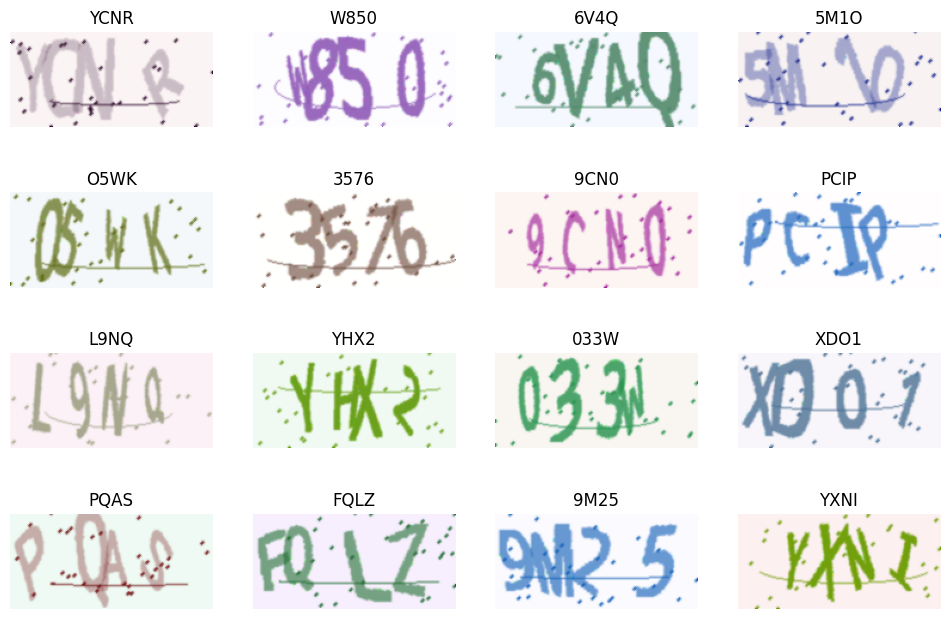

In [44]:
import matplotlib.pyplot as plt
import string
import numpy as np

# Step 1: Create an instance of the generator
generator = gen2(batch_size=16, height=80, width=170, n_len=4, n_class=36)

# Step 2: Get a batch of images and labels from the generator
X, y = next(generator)

# Step 3: Use matplotlib to display the images
plt.figure(figsize=(12, 8))
characters = string.digits + string.ascii_uppercase  # Include both digits and uppercase letters

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    print(i)

    context = ''.join([characters[idx] for idx in np.argmax(y[i], axis=1)])
    print(context)
    plt.title(context)

plt.show()


# 圖像拆分與辨識

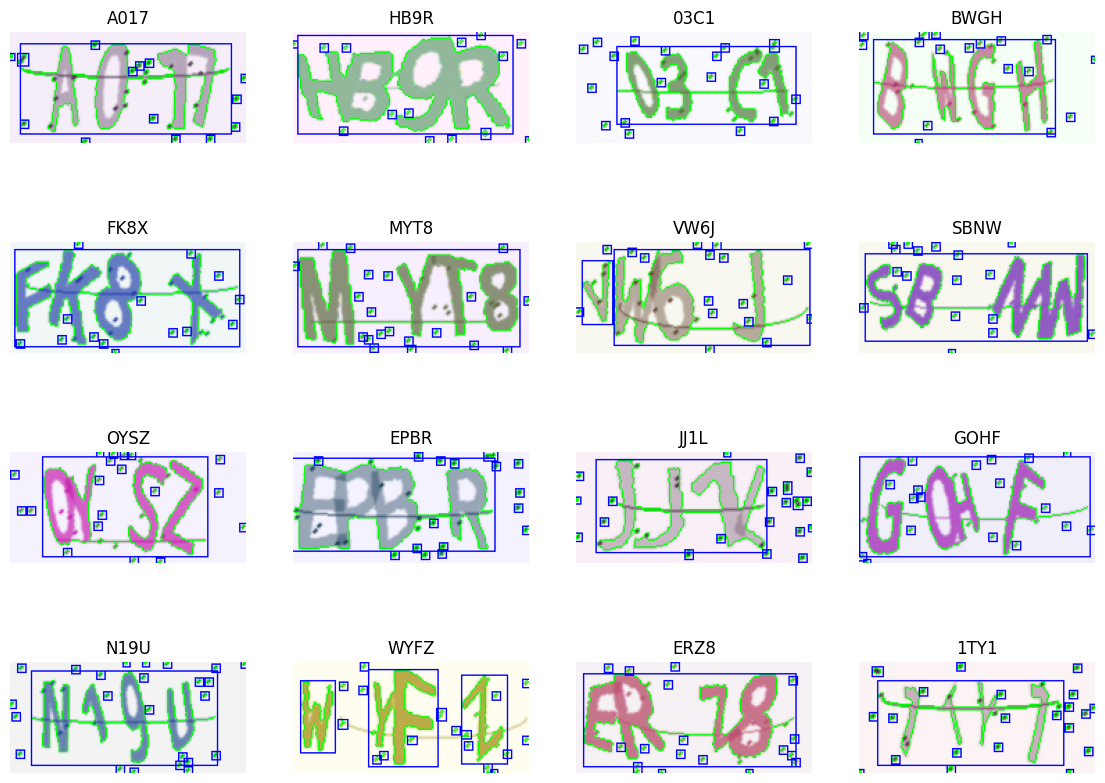

In [56]:
import matplotlib.pyplot as plt
import string
import numpy as np
import cv2
# Create an instance of the generator
generator = gen2(batch_size=16, height=80, width=170, n_len=4, n_class=36)

# Get a batch of images and labels from the generator
X, y = next(generator)

fig = plt.figure(figsize=(14, 10))

plt_rows = 4
plt_cols = 4
plt_iter = 1

plt.subplots_adjust(hspace=0.5)

characters = string.digits + string.ascii_uppercase
for i in range(plt_rows * plt_cols):
    plt.subplot(plt_rows, plt_cols, plt_iter)

    # Use the generated image
    img = X[i]
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take binary threshold
    ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    # Invert image
    bit_not = cv2.bitwise_not(thresh)
    # Find contours
    contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Draw on original image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 1)
    # Get bounding rect of each contour
    rects = [cv2.boundingRect(c) for c in contours]
    # Sort rects by their width
    rects.sort(key=lambda x: x[2])

    # Deal with touching letters where one wide bounding box
    # envelops two letters. split these in half
    while len(rects) < 4:
        # Pop widest rect
        wide_rect = rects.pop()
        x, z, w, h = wide_rect
        # Split in two
        first_half = (x, z, w // 2, h)
        second_half = (x + w // 2, z, w // 2, h)
        rects.append(first_half)
        rects.append(second_half)
        # Re-sort rects by their width
        rects.sort(key=lambda x: x[2])

    for rect in rects:
        x, z, w, h = rect
        # Buffer rect by 1 pixel
        cv2.rectangle(img, (x - 1, z - 1), (x + w + 1, z + h + 1), (255, 0, 0), 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Corrected title extraction
    captcha_text = ''.join([characters[idx] for idx in np.argmax(y[i], axis=1)])
    plt.title(captcha_text)

    plt_iter += 1
plt.show()


In [59]:
import string
import numpy as np
import cv2
import os

# Define the generator function as provided earlier
def gen2(batch_size=16, height=80, width=170, n_len=4, n_class=36, save_dir='captcha_images'):
    from captcha.image import ImageCaptcha
    import string
    import random
    import numpy as np
    import os

    characters = string.digits + string.ascii_uppercase

    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len, n_class), dtype=np.uint8)
    generator = ImageCaptcha(width=width, height=height)

    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[i, j, characters.find(ch)] = 1

            # Save image to disk
            img_name = f'{random_str}.png'
            img_path = os.path.join(save_dir, img_name)
            cv2.imwrite(img_path, X[i])

        yield X, y

# Create a directory to save images if it doesn't exist
save_dir = 'captcha_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Create an instance of the generator
generator = gen2(batch_size=16, height=80, width=170, n_len=4, n_class=36, save_dir=save_dir)

# Get a batch of images and labels from the generator
X, y = next(generator)


In [58]:
import os
import os.path
import cv2
import glob
import imutils


CAPTCHA_IMAGE_FOLDER = "/content/drive/MyDrive/CNN/captcha_images"
OUTPUT_FOLDER = "/content/drive/MyDrive/CNN/output"


# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1


[INFO] processing image 1/48


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/shapedescr.cpp:874: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function 'pointSetBoundingRect'


# CNN VGG 16 Github


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from PIL import Image
import numpy as np
import csv
print("Creating CNN model...")
lin = Input((60, 200, 3))
out = lin
out = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(out)
out = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.3)(out)
out = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(out)
out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.3)(out)
out = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(out)
out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Dropout(0.3)(out)
out = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(out)
out = BatchNormalization()(out)
out = MaxPooling2D(pool_size=(2, 2))(out)
out = Flatten()(out)
out = Dropout(0.3)(out)
out = [Dense(34, name='digit1', activation='softmax')(out),\
    Dense(34, name='digit2', activation='softmax')(out),\
    Dense(34, name='digit3', activation='softmax')(out),\
    Dense(34, name='digit4', activation='softmax')(out),\
    Dense(34, name='digit5', activation='softmax')(out)]
model = Model(inputs=lin, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Creating CNN model...


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 60, 200, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 60, 200, 32)    │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 58, 198, 32)    │          9,248 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 58, 198, 32)    │            128 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 29, 99, 32)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 29, 99, 32)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 29, 99, 64)     │         18,496 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 27, 97, 64)     │         36,928 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 27, 97, 64)     │            256 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 13, 48, 64)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 13, 48, 64)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 13, 48, 128)    │         73,856 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 11, 46, 128)    │        147,584 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 11, 46, 128)    │            512 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 5, 23, 128)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 5, 23, 128)     │              0 │ max_pooling2d_6[0][0]  │
├──────────────────────

 Total params: 1,019,466 (3.89 MB)

 Trainable params: 1,018,506 (3.89 MB)

 Non-trainable params: 960 (3.75 KB)

# ResNet Running

In [62]:
# 構建和訓練模型
model = resnet50_with_batchnorm_dropout(input_shape=(80, 170, 3), n_class=36, dropout_rate=0.25)
model.summary()
train_dataset = tf.data.Dataset.from_generator(
    lambda: gen2(),
    output_signature=(
        tf.TensorSpec(shape=(None, 80, 170, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4, 36), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: gen2(),
    output_signature=(
        tf.TensorSpec(shape=(None, 80, 170, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4, 36), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

model.fit(train_dataset, steps_per_epoch=512, epochs=5, validation_data=validation_dataset, validation_steps=512)

# # 保存模型权重
model.save_weights("/content/drive/MyDrive/CNN/model_Resnet.weights.h5")

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 80, 170, 3)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 86, 176, 3)     │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 40, 85, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 40, 85, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 40, 85, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 42, 87, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 20, 43, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 20, 43, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 20, 43, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 20, 43, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 20, 43, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 20, 43, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 20, 43, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 20, 43, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 20, 43, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 28,896,272 (110.23 MB)

 Trainable params: 28,843,152 (110.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 351s 498ms/step - accuracy: 0.0292 - loss: 149.1821 - val_accuracy: 0.0262 - val_loss: 161.9564
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 249s 487ms/step - accuracy: 0.0279 - loss: 183.8341 - val_accuracy: 0.0270 - val_loss: 171.5386
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 247s 483ms/step - accuracy: 0.0269 - loss: 180.9062 - val_accuracy: 0.0280 - val_loss: 169.1798
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 257s 502ms/step - accuracy: 0.0261 - loss: 177.9051 - val_accuracy: 0.0252 - val_loss: 166.8413
Epoch 5/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 266s 520ms/step - accuracy: 0.0282 - loss: 175.2512 - val_accuracy: 0.0272 - val_loss: 164.3907


# Model Running

In [ ]:
model = vgg16_with_batchnorm_dropout(input_shape=(80, 170, 3), n_class=36, dropout_rate=0.25)
model.summary()

In [ ]:
# model = model(height, width)
# 使用模型進行測試
model = model.load_weights('/content/drive/MyDrive/CNN/model.weights.h5')
# test_model(model)
X, y = next(gen(1))

# 测试一个样本
y_pred = model.predict(X)
plt.title('real: %s\npred:%s' % (decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.show()

print("模型总体准确率：", evaluate(model))

AttributeError: 'NoneType' object has no attribute 'predict'